![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

 
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/fakultaet3/gt/soilmechanics

# Benchmark: Sneddon lower-dimensional interface elements without fracture propagation (static)

The Fluid is injected at the left side of the fracture. In this static case no fracture propagation occures and the simulation ends with reaching the breakdown pressure.

<center>
<figure>
      <img src="Sneddon-static.png" alt="Benchmark" style="width:40%">
       <figcaption style="line-height:1.5;width:80%" >  
        Fig.1.: Geometry of the Sneddon benchmark.
     </figcaption>
</figure>
</center>

In [1]:
#! /opt/anaconda/bin/ python3.8
import math
from ogs6py.ogs import OGS
import vtuIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #für Farb en
plt.rcParams.update({'font.size': 16})
import plot_settings

The static model can be used to compare it the analytic solution (Sneddon) at the beginning of the crack propagation.
- calculate critical volume and time after Sneddon (setup numerical model)

In [2]:
qin  = 2e-6  #total injection rate
qin_sym = qin/2  #injection rate in symmetric geometry
nu   = 0.15
E    = 80e9

#Fracture properties
Enu  = E/(1-nu**2)
Gc   = 20     #fracture thoughness
b0   = 1e-4   #aperture at t=0 in a0
a0   = 0.1    #initial fracture lenght [m]
a02   = 0.2    #fracture evaluation lenght[m]

Vc=(4*np.pi*Gc*a0**3/Enu)**(0.5)
pc=(Gc*Enu/np.pi/a0)**(0.5)
tc=Vc/qin
p_V=(2*Enu*Gc**2/np.pi/(tc*qin))**(1/3) #pressure after x seconds (t min = tc)

print("Vc  [m³/s] = "+str(Vc)) # required injected Volume to initialise fracture propagation
print("pc  [Pa]   = "+str(pc)) # required pressure to initialise fracture propagation
print("p_V [Pa]   = "+str(p_V))
print("tc  [s]    = "+str(tc)) # initialization fracture propagation


Vc  [m³/s] = 1.7524003021239251e-06
pc  [Pa]   = 2282583.491427138
p_V [Pa]   = 2282583.491427136
tc  [s]    = 0.8762001510619626


In [3]:
#Reading the OGS project files:
pvd_static_rate=OGS(INPUT_FILE="crack_propagation_CL_rate.prj", PROJECT_FILE="crack_static_CL_rate.prj")

In [4]:
pvd_static_rate.replace_text(tc, xpath="./time_loop/processes/process/time_stepping/t_end")
pvd_static_rate.replace_text(tc/100, xpath="./time_loop/processes/process/time_stepping/dt_guess")
pvd_static_rate.replace_text(tc/1000, xpath="./time_loop/processes/process/time_stepping/dt_min")
pvd_static_rate.replace_text(tc/10, xpath="./time_loop/processes/process/time_stepping/dt_max")

#create injection curve
string=str(0)+" "+str(tc)
pvd_static_rate.replace_text(string, xpath="./curves/curve[name='curve_q_in']/coords")
string=str(qin_sym)+" "+str(qin_sym)
pvd_static_rate.replace_text(string, xpath="./curves/curve[name='curve_q_in']/values")

pvd_static_rate.replace_parameter(name="nu",value=nu)
pvd_static_rate.replace_parameter(name="E",value=E)

pvd_static_rate.write_input()

True

In [5]:
PATH_OGS="/home/mok/ogs_release/bin/"
pvd_static_rate.run_model(path=PATH_OGS)

OGS finished with project file crack_static_CL_rate.prj.
Execution took 22.694950342178345 s


In [6]:
import vtuIO
pvd_static_rate = vtuIO.PVDIO("Center_Crack_IP.pvd", dim=2)

Center_Crack_IP.pvd


In [7]:
line_0=[(i,1.0,0) for i in np.linspace(start=0.0, stop=a02, num=40)]
lines = {'crack': line_0,}

''

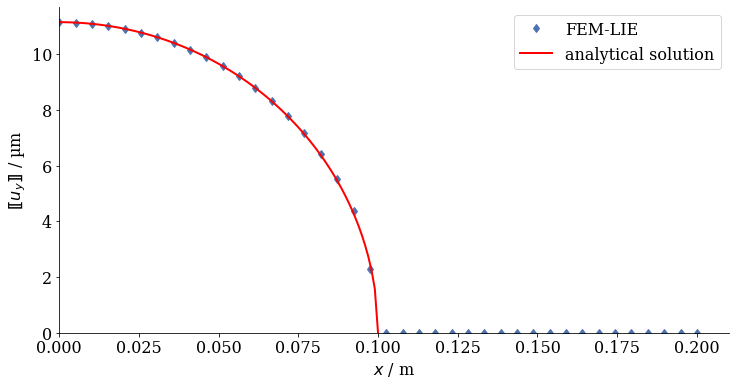

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(0,a02,40)
for i in lines:
    static_rate1 = pvd_static_rate.read_point_set_data(tc,'displacement_jump1', pointsetarray=lines[i]).T[1]
    ax.plot(x,-static_rate1*1e6, label='FEM-LIE',ls='',marker='d')

uy = lambda x: 2*2*pc*a0/Enu*(1-x**2/a0**2)**(0.5)
x = np.linspace(0,a0,100)
ax.plot(x,uy(x)*1e6,label='analytical solution', ls='-', color='r')

ax.set_xlabel('$x$ / m')
ax.set_ylabel('$[\![ u_y ]\!]$ / µm')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.legend()
;

In [9]:
line_02=[(i,1.0,0) for i in np.linspace(start=0.0, stop=a02, num=100)]
lines = {'crack': line_02,}

Integration of the displacement change $\Delta u$ to calculate the volume change of the fracture:

$$
\Delta u(x)=\frac{2pa_\text{0}}{E'}\sqrt{1-\frac{x^\mathrm{2}}{a^\mathrm{2}_\text{0}}}
$$

$$
\Delta V(x)=\frac{2pa_\text{0}}{E'}\left ((a_\text{0}\arcsin\frac{x}{a_\text{0}})+a_\text{0}\sqrt{1-\frac{x^\mathrm{2}}{a^\mathrm{2}_\text{0}}}\right )
$$

In [10]:
#fracture lenght analytic
aV1=(Enu*(tc*qin)**2/(4*np.pi*Gc))**(1/3)
print('fracture lenght analytic [m]')
print(aV1)

#fracture total volume numeric
print(' ')
print('fracture volume numeric [m³]')
print(abs(2*a02*np.mean(static_rate1)))

#fracture volume analytic
V1anl=(4*np.pi*Gc*aV1**3/Enu)**(0.5)
print(' ')
print('fracture volume analytic [m³]')
print(V1anl)
p1anl=(Gc*Enu/np.pi/aV1)**(0.5)

print(' ')
print('fracture volume analytic (integration) [m³]')
#V=2*p1anl*aV1/Enu*((aV1*np.arcsin(x/aV1))+aV1*(1-x**2/aV1**2)**(1/2))*2
V1anl_2=2*p1anl*aV1/Enu*((aV1*np.arcsin(aV1/aV1))+aV1*(1-aV1**2/aV1**2)**(1/2))*2
print(V1anl_2)

fracture lenght analytic [m]
0.10000000000000002
 
fracture volume numeric [m³]
1.766580095209948e-06
 
fracture volume analytic [m³]
1.7524003021239256e-06
 
fracture volume analytic (integration) [m³]
1.7524003021239253e-06


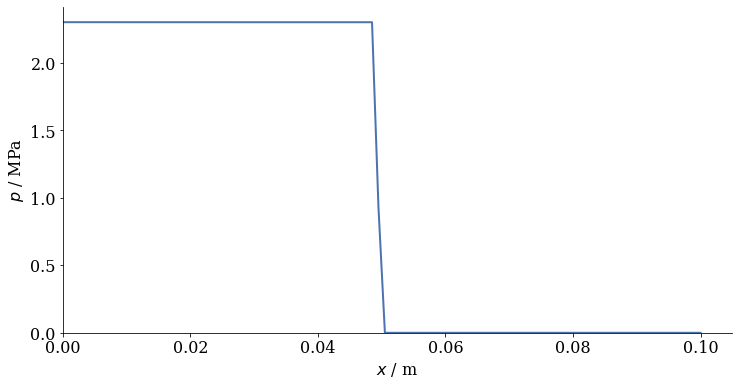

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(0,a0,100)
#x = np.linspace(0,0.095,100)
for i in lines:
    static_rate1 = pvd_static_rate.read_point_set_data(tc,'pressure_interpolated', pointsetarray=lines[i])
    ax.plot(x,static_rate1/1e6,  label="FEM-LIE",ls='-')

#ax.legend()
ax.set_xlabel('$x$ / m')
ax.set_ylabel('$p$ / MPa')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0);

In [12]:
#Punktauswahl:
pt_in = {"pt0": (0,1,0)}
pt_out = {"pt01": (0.1,1,0)}

# Ergebnisdatasets:
results_pt0  = {}
results_pt01 = {}

In [13]:
results_pt0["pressure"]=pvd_static_rate.read_time_series("pressure",pts=pt_in)
results_pt01["pressure"]=pvd_static_rate.read_time_series("pressure",pts=pt_out)

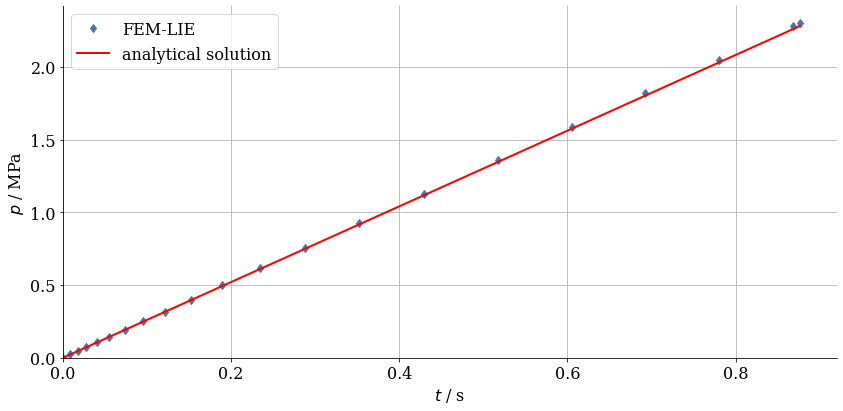

In [14]:
pt0_points=(results_pt0['pressure']['pt0'])
pt01_points=(results_pt01['pressure']['pt01'])

#Title=('Pressure over Time')
Figname=('Pressure_over_time_p0.pdf')


fig, ax = plt.subplots(figsize=(12,6))
    
ax.plot(pvd_static_rate.timesteps,pt0_points/1e6,label='FEM-LIE',ls='',marker='d')


steps = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
x = np.linspace(0,1,100)
p_sol = lambda x: x*(2*Enu*Gc**2/np.pi/(tc*qin))**(1/3)
ax.plot(x*tc,p_sol(x)/1e6, ls='-',color='r',label='analytical solution')

ax.set_xlabel('$t$ / s')
ax.set_ylabel('$p$ / MPa')
#plt.title(Title)
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

plt.grid()
fig.tight_layout()
plt.show
plt.savefig(Figname)
#;

In [15]:
results_pt0  = {}
results_pt0["HydraulicFlow"]=pvd_static_rate.read_time_series("HydraulicFlow",pts=pt_in)
pt0_points=(results_pt0['HydraulicFlow']['pt0'])


print(results_pt0)

{'HydraulicFlow': {'pt0': array([ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])}}


In [16]:
results_pt0["displacement_jump1"]=pvd_static_rate.read_time_series("displacement_jump1",pts=pt_in)
results_pt01["displacement_jump1"]=pvd_static_rate.read_time_series("displacement_jump1",pts=pt_out)


''

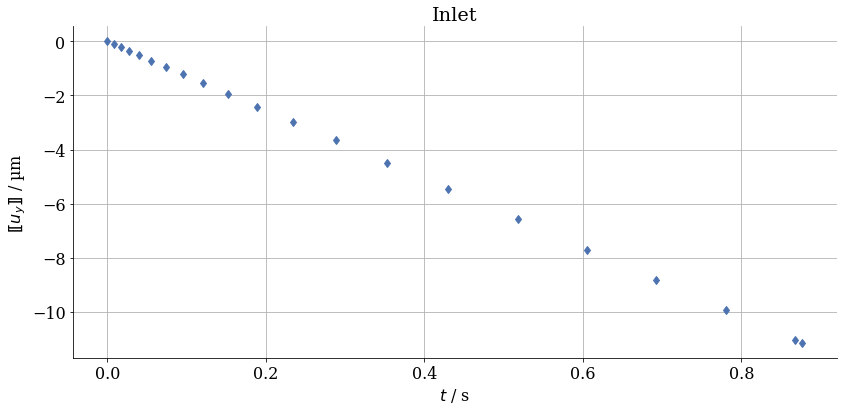

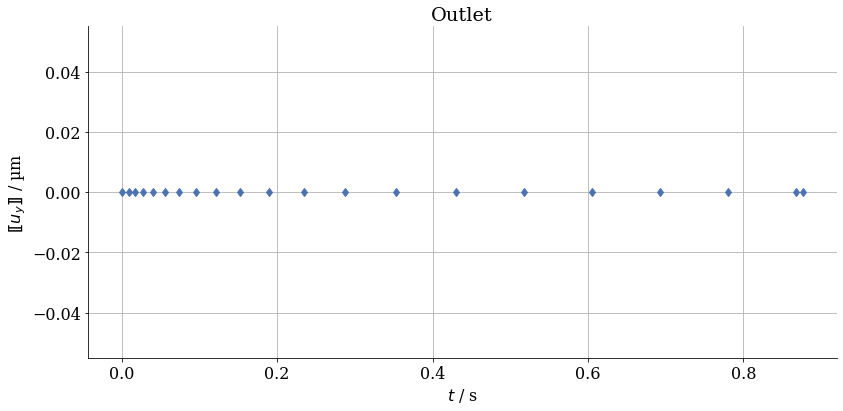

In [19]:
pt0_points_disp=(results_pt0['displacement_jump1']['pt0'],results_pt01['displacement_jump1']['pt01'])
Title=('Inlet','Outlet')
Figname=('Disp_over_time_p0.pdf','Disp_over_time_p01.pdf')

for pt0_points_disp,title,figname in zip(pt0_points_disp,Title,Figname):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(pvd_static_rate.timesteps,pt0_points_disp.T[1]*1e6,label='FEM-LIE',ls='',marker='d')
    
    ax.set_xlabel('$t$ / s')
    ax.set_ylabel('$[\![ u_y ]\!]$ / µm')
    plt.title(title)
    #ax.legend()
    #ax.plot(2,-1e-5,label='LIEx', marker='d')
    # plt.ylim(1.1e7,1.15e7)
    plt.grid()
    fig.tight_layout()
    plt.show
    plt.savefig(figname)
;